# Sequence to Sequence code part




## Import packages

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
! python -m spacy download de
! pip install torchtext==0.6.0
from torchtext.data import Field, BucketIterator,TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     |████████████████████████████████| 14.9MB 13.3MB/s 
  Created wheel for de-core-news-sm: filename=de_core_news_sm-2.2.5-cp37-none-any.whl size=14907057 sha256=bd00ced596a58954e7a491f4736e0bfdd6878d6636b727c64435e3e535c45ad3
  Stored in directory: /tmp/pip-ephem-wheel-cache-864e7r9h/wheels/ba/3f/ed/d4aa8e45e7191b7f32db4bfad565e7da1edbf05c916ca7a1ca
Successfully built de-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/de_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/de
You can now load the model via spacy.load('de')
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 1.2MB 21.4MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


## Preparing Data

To prepare the input test, we use the tools provided by torchtext.

First of all , we deifine the two different fields. Fiels contains a set of generic parameters for text processing, and also contains a dictionary object that can represent text data as numeric types, which in turn can represent text as the desired tensor type


In [ ]:
# load token tools
spacy_deutsch = spacy.load('de')
spacy_english = spacy.load('en')

# Define the token function
def tokenize_de(text):
    """Tokenizes German text:  
    """
    return [tok.text for tok in spacy_deutsch.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_english.tokenizer(text)]

# Define the Field object
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            include_lengths = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

Before importing the .txt data, we have splited and coverted the originial data into .csv data. The TabularDataset read the .csv file and process them with predefinded Field pattern. 

In [ ]:
# load the prepared csv data
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Dataset/s2s/'
train_dataset, val_dataset, test_dataset = TabularDataset.splits(
        path=file_path, train='train.csv',
        validation='val.csv', test='test.csv', format='csv',
        fields=[('src', SRC), ('trg', TRG)], skip_header = True)

Mounted at /content/drive


The demonstration of *_dataset looks like this:

In [ ]:
print("What the dataset looks like:\n")
# print(train_dataset[5])
# print(train_dataset[5].__dict__.keys())
print(train_dataset[5].src)
print(train_dataset[5].trg)

What the dataset looks like:

['let', "'s", 'put', 'this', 'money', 'aside', 'for', 'our', 'summer', 'trip', '.']
['legen', 'wir', 'dieses', 'geld', 'für', 'unsere', 'sommerreise', 'beiseite', '.']



It is very convient to create a vocabuliary of both language. Becauses the train dataset contains the most of sentences, we use it to collect the vocabulary. Then we also set the minimun frequence of vocabulary is 2.


In [ ]:
SRC.build_vocab(train_dataset)
TRG.build_vocab(train_dataset)
print(">> the number of words (or the length of dictionary) is: ", len(SRC.vocab))
print(">> the token of {} is {}".format("<pad>",SRC.vocab.stoi["<pad>"]))
print(">> the token of {} is {}".format(SRC.init_token,SRC.vocab.stoi[SRC.init_token]))
print(">> the token of {} is {}".format(SRC.eos_token,SRC.vocab.stoi[SRC.eos_token]))


>> the number of words (or the length of dictionary) is:  13367
>> the token of <pad> is 1
>> the token of <sos> is 2
>> the token of <eos> is 3


Next, we product itrator. The BuckeIterator is a very good tool which can help us to batch the data and add the padding automatically.

In [ ]:
BATCH_SIZE = 16

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_dataset, val_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch=True,
     sort_key = lambda x: len(x.src),
     device = device)

train_iterator looks like this:

In [ ]:
batch = next(iter(train_iterator))
print(batch.src)

(tensor([[   2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
            2,    2,    2,    2],
        [  18,  108,   71,    8,    7,  136,   37,   33,   37,    5,   83,   83,
          203,   16,   43,   71],
        [   7,    9,  131,   65,   27,  168,   99, 1536,    5,   15,   73,   45,
          306,   20,  234,   65],
        [  24, 4358,    5,    6,   24,    6,  787,   11,   35,   11,    7,    7,
           98,   42,   23,   65],
        [  11,  154,   12,   92,    6,   96,   19,  485,   37,  288,   74,   96,
          418,   44,   69,   13],
        [2621,    9,   54,    9,  159,    9,  200,   19,   82,  345,   14,   13,
            6,   58,  351,  239],
        [ 351,  506,  470,  387,   14,  461,  626, 3251, 3133,   91,  224,  505,
          256, 1252,  485,  156],
        [  10,    4,    4,    4,    4,    4,    4,    4,    4,    4,   10,   10,
            4,    4,    4,    4],
        [   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3

## Model Definition  


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, embed_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        """Here we define the encoder model.
        The embedding is at the entrance. And the main RNN module is GRU.
        """
        self.embedding = nn.Embedding(input_dim, embed_dim)
        self.rnn = nn.GRU(embed_dim, enc_hid_dim, bidirectional = False)
        # one, because we just use one diretional RNN
        self.fc = nn.Linear(enc_hid_dim * 1, dec_hid_dim)
        self.dropout = nn.Dropout(dropout)
        self.Norm = nn.BatchNorm1d(dec_hid_dim)
        
    def forward(self, source, source_len):
        """
        :param source : (source_len, batch_size)
        :param source_len: (batch_size)
        return:
            outputs : (source_len, batch_size, enc_hid_dim * 1)
            hidden : (batch_size, dec_hid_dim)
        """
        # embedded: (source_len, batch_size, embed_dim)
        embedded = self.dropout(self.embedding(source))
        # NOTE: source_len run only in cpu
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded, source_len.cpu())                
        pack_outputs, hidden = self.rnn(pack_embedded)
        # only unpack outputs
        outputs, _ = nn.utils.rnn.pad_packed_sequence(pack_outputs) 
        # bi
        # hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        # # single
        hidden = torch.tanh(self.fc(hidden))
        hidden = hidden.squeeze(0)        

        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 1) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        """
        :param hidden: from the last encoder or decoder, size is (batch_size, dec_hid_dim)
        :param encoder_outputs: contain all ouputs from encoder, size is (source_len, batch_size, enc_hid_dim * 1)
        return:
            attention: (batch_size, source_len)
        """
        
        batch_size = encoder_outputs.shape[1]
        source_len = encoder_outputs.shape[0]
        
        # repeat decoder hidden state source_len times to cat them 
        # (batch_size, source_len, dec_hid_dim)
        hidden = hidden.unsqueeze(1).repeat(1, source_len, 1)

        # (batch_size, source_len, enc_hid_dim * num_directions)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        # (batch_size, source_len, dec_hid_dim)
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2)))  
        
        attention = self.v(energy).squeeze(2)
        
        # (batch_size, source_len)
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, embed_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, embed_dim)
        self.rnn = nn.GRU((enc_hid_dim *1) + embed_dim, dec_hid_dim)
        # previous design
        # self.projection  = nn.Linear((enc_hid_dim *1) + dec_hid_dim + embed_dim, output_dim)
        self.projection  = nn.Linear((enc_hid_dim *1) + dec_hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        """ Decoder also contains the attention
        :param input: (batch_size)
        :param hidden: (batch_size, dec_hid_dim)
        :param encoder_outputs: (source_len, batch_size, enc_hid_dim * num_directions)
        :param mask : (batch_size, source_len)
        """

        # (1, batch_size)
        input = input.unsqueeze(0)
        
        # (1, batch_size, embed_dim)
        embedded = self.dropout(self.embedding(input))
        
        # (batch_size, source_len)
        a = self.attention(hidden, encoder_outputs, mask)
                
        # (batch_size, 1, source_len)
        a = a.unsqueeze(1)
        
        #(batch_size, source_len, enc_hid_dim * num_directions) <- num_directions = 1
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # (batch_size, 1, enc_hid_dim * num_directions)
        weighted = torch.bmm(a, encoder_outputs)
        
        # (1, batch_size, enc_hid_dim * num_directions)
        weighted = weighted.permute(1, 0, 2)

        # (1, batch_size, (enc_hid_dim * num_directions) + embed_dim)
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        # output : [seq_len, batch_size, dec_hid_dim * num_directions]
        # hidden : [n_layers * num_directions, batch_size, dec_hid_dim]    
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        # seq_len, n_layers and num_directions will always be 1 in this decoder, therefore:
        # output: (1, batch_size, dec_hid_dim)
        # hidden: (1, batch_size, dec_hid_dim)
        # this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)

        # previous design: 
        # pred = self.projection(torch.cat((output, weighted, embedded), dim = 1))
        # (batch_size, output dim)
        pred = self.projection(torch.cat((output, weighted), dim = 1))

        
        return pred, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, device):
        super().__init__()
        """Sequence to sequence class consists of encoder decoder and attention 
        (in decoder).
        """
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.device = device
    
    def create_mask(self, source):
        mask = (source != self.pad_idx).permute(1, 0)
        return mask
 
    def forward(self, source, source_len, target, tf_ratio = 0.5):
        """
        :param source : (source_len, batch_size)
        :param source_len = (batch_size)
        :param target = (target_len, batch_size)
        :param tf_ratio is probability to use teacher forcing
        """

        batch_size = source.shape[1]
        target_len = target.shape[0]
        target_vocab_size = self.decoder.output_dim
        
        # prepare the output : (target_len, batch_size, target_vocab_size)
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
        
        # encoder_outputs contains all hidden states
        # hidden is the final forward and backward hidden states, passed through a linear layer
        # Because we want to calculate attention.
        enc_outputs, hidden = self.encoder(source, source_len)
        # take the first <sos> token in batch
        target_input = target[0,:]
        
        # Ceate mask size (batch_size, source_len)
        mask = (source != self.pad_idx).permute(1, 0)
        
        for t in range(1, target_len):
            
            # target_input: embedding token, hidden: previous hidden state, encoder_ouputs: all encoder hidden state
            # return: pred and previous hidden state
            output, hidden, _ = self.decoder(target_input, hidden, enc_outputs, mask)
            
            # insert predictions 
            outputs[t] = output
            
            # teacher forcing
            if random.random() < tf_ratio: 
                target_input = target[t]
            else:
                target_input = output.argmax(1)             
            
        return outputs

## Training the Model


In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        # take source and target from batch
        source,source_len = batch.src
        target = batch.trg

        optimizer.zero_grad()
                
        # trg: (target_len, batch_size)
        # output: (target_len, batch_size, output dim_
        output = model(source, source_len, target)       
        output_dim = output.shape[-1]
        
        # ((target_len - 1) * batch_size, output dim)
        output = output[1:].view(-1, output_dim)
        # ((target_len - 1) * batch_size)
        target = target[1:].view(-1)
        
        # add l1
        # l1_regularization = torch.cuda.FloatTensor(1)
        # l2_regularization = torch.cuda.FloatTensor(1)
        # for param in model.parameters():
        #     l1_regularization += torch.norm(param, 1)
        #     l2_regularization += torch.norm(param, 2)

        loss = criterion(output, target)
        loss.backward()
        # make a clip
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()

        if i != 0 and i % 100 == 0: # 
            print(i," ",epoch_loss/i)
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            source, source_len = batch.src
            target = batch.trg

            # target: (target_len, batch_size)
            # output: (target_len, batch_size, output dim)
            output = model(source, source_len, target, 0) #turn off teacher forcing
            output_dim = output.shape[-1]

            # ((target_len - 1) * batch_size, output dim)
            output = output[1:].view(-1, output_dim)

            # ((target_len - 1) * batch_size)
            target = target[1:].view(-1)


            loss = criterion(output, target)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

source_dim = len(SRC.vocab)
target_dim = len(TRG.vocab)
# encoder_embedding_dim = 256
# decoder_embedding_dim = 256
# encoder_hidden_dim = 512
# decoder_hidden_dim = 512
encoder_embedding_dim = 128
decoder_embedding_dim = 128
encoder_hidden_dim = 256
decoder_hidden_dim = 256
dropout_rate = 0.5

attnention = Attention(encoder_hidden_dim, decoder_hidden_dim).to(device)
encoder = Encoder(source_dim, encoder_embedding_dim, encoder_hidden_dim, decoder_hidden_dim, dropout_rate).to(device)
decoder = Decoder(target_dim, decoder_embedding_dim, encoder_hidden_dim, encoder_hidden_dim, dropout_rate, attnention).to(device)

model = Seq2Seq(encoder, decoder, SRC.vocab.stoi["<pad>"], device).to(device)
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')


optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG.vocab.stoi["<pad>"])

epochs = 10
clip = 1

best_valid_loss = float('inf')

The model has 19,332,959 trainable parameters


In [ ]:

# Plot record
epoch_times =  []
train_losses = []
val_losses =   []
all_start_time = time.time()

for epoch in range(epochs):
    # start time
    start_time = time.time()
    # train and validation
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    # end time
    end_time = time.time()
    # print time
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # preapare the plot list
    epoch_times.append(end_time-start_time)
    train_losses.append(train_loss)
    val_losses.append(valid_loss)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/Dataset/s2s/s2s_model_embed128_hidden256.pt')
    
    print('Epoch: {} Time: {}m {}s'.format(epoch,epoch_mins,epoch_secs))
    print('>>> Train Loss: ',train_loss)
    print('>>> Val   Loss: ',valid_loss)

all_end_time = time.time()
print(">> total time of training: ", epoch_time(all_start_time, all_end_time))

100   6.794950475692749
200   6.293026471138001
300   6.029053743680318
400   5.851054993867874
500   5.722632300376892
600   5.609805857340495
700   5.524095636435917
800   5.445248492360115
900   5.375201457076603
1000   5.313952425956726
1100   5.259991460713473
1200   5.213534526228905
1300   5.162544574920948
1400   5.114168120622635
1500   5.073364452203115
1600   5.033447348326445
1700   4.9952739083065705
1800   4.957588662703832
1900   4.9228472909174465
2000   4.888362424850464
2100   4.856203596932548
2200   4.825615351200104
2300   4.792279144370037
2400   4.762384712795416
2500   4.732914888286591
2600   4.704798528322807
2700   4.675892066425748
2800   4.648316361733845
2900   4.620702803874838
3000   4.595820471922557
3100   4.5706430618224605
3200   4.545120609253645
3300   4.519480283910578
3400   4.495989344751133
3500   4.472069205284119
3600   4.44922701438268
3700   4.426908166859601
3800   4.40431295231769
3900   4.384629691869785
4000   4.364116539418697
4100   4

[3.2152866665916564, 2.840768231246286, 2.7302188272315755, 2.712242522452474, 2.7234044268085706, 2.721583623414642, 2.7367313715733115, 2.7283148446805736, 2.762491474829408, 2.7521819017672424]


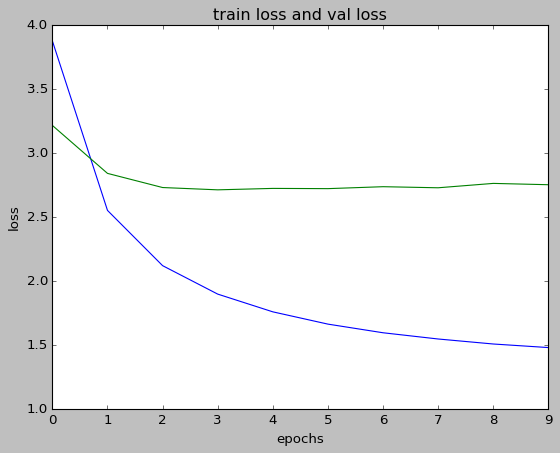

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('classic')

x = np.linspace(0, 10, 100)
plt.title("train loss and val loss")
plt.plot(range(len(train_losses)),train_losses)
plt.plot(range(len(val_losses)),val_losses)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Dataset/s2s/s2s_model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print('>>> Test Loss: {}'.format(test_loss))

>>> Test Loss: 2.7062480459704097


In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    """
    :param sentence: you want to translate
    :param src_field: source language field object
    :param trg_filed: target language field object
    :param model: the model to translate
    :param device: cuda or cpu
    :param max_len: the max sentence length you want to translate
    return:
        trg_tokens : target sentence 
        attentions : attention matrix to plot
    """
    model.eval()
        
    # sentenct to tokens 
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        words = [word.text.lower() for word in nlp(sentence)]
    else:
        words = [word.lower() for word in sentence]

    # it is still a word list, not numerical list
    words = [src_field.init_token] + words + [src_field.eos_token]
    # convert to token
    src_indexes = [src_field.vocab.stoi[word] for word in words]
    # to tensor and set in cuda
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # ?
    source_len = torch.LongTensor([len(src_indexes)]).to(device)
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, source_len)
    # make mask
    mask = model.create_mask(src_tensor)
    # first token
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):
        # take last output
        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)
        # update attention
        attentions[i] = attention
        # greedy search
        pred_token = output.argmax(1).item()
        # recode in index
        trg_indexes.append(pred_token)
        # if end break
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    # token to words
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

## Attention Display

In [ ]:
def display_attention(sentence, translation, attention):
    """ To
    """
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

## Training dataset testing

source: ['coming', 'here', 'was', 'a', 'mistake', '.']
target: ['es', 'war', 'ein', 'fehler', ',', 'hierher', 'zu', 'kommen', '.']
predicted: ['komm', 'hier', ',', 'einen', 'fehler', 'fehler', '!', '<eos>']


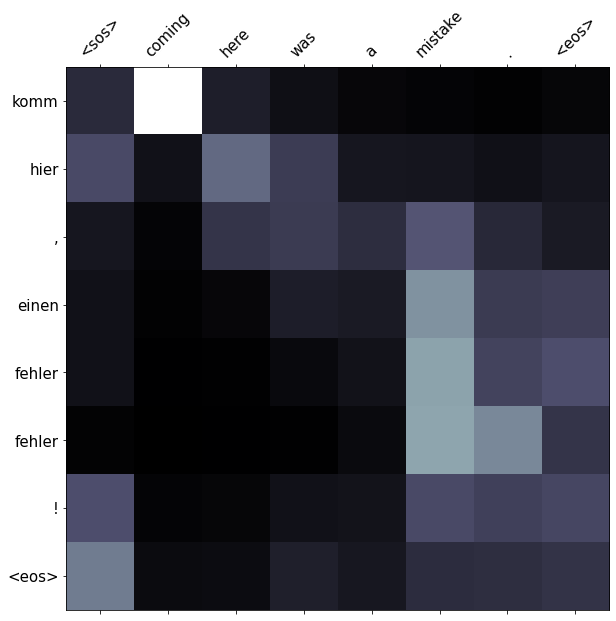

In [ ]:
example_idx = 22

src = vars(train_dataset.examples[example_idx])['src']
trg = vars(train_dataset.examples[example_idx])['trg']

print('source: {}'.format(src))
print('target: {}'.format(trg))
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print('predicted: {}'.format(translation))

display_attention(src, translation, attention)

## Validation dataset testing

source: ['she', 'made', 'him', 'a', 'simple', 'dinner', '.']
target: ['sie', 'machte', 'ihm', 'ein', 'einfaches', 'essen', '.']
predicted: ['sie', 'machte', 'ihm', 'ein', 'leicht', 'zum', 'mittagessen', '.', '<eos>']


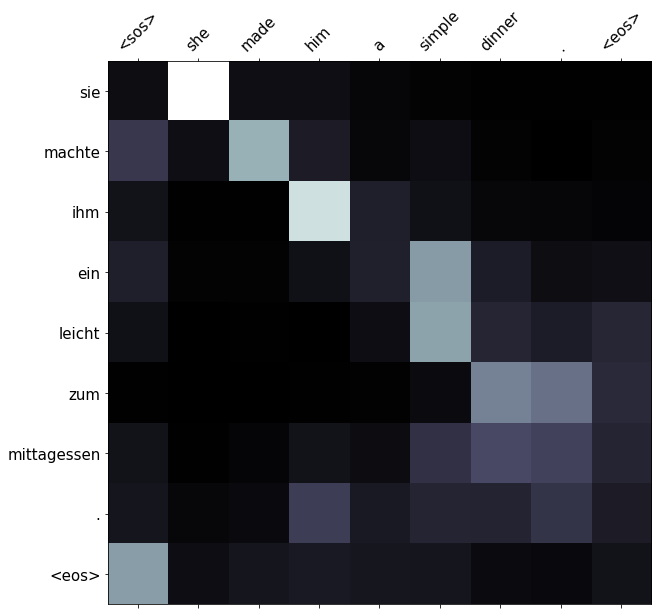

In [ ]:
example_idx = 44

src = vars(val_dataset.examples[example_idx])['src']
trg = vars(val_dataset.examples[example_idx])['trg']

print('source: {}'.format(src))
print('target: {}'.format(trg))
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print('predicted: {}'.format(translation))

display_attention(src, translation, attention)

## Test dataset Testing 

source: ['what', 'motivated', 'you', '?']
target: ['was', 'hat', 'sie', 'angetrieben', '?']
predicted: ['was', 'motiviert', 'euch', '?', '<eos>']


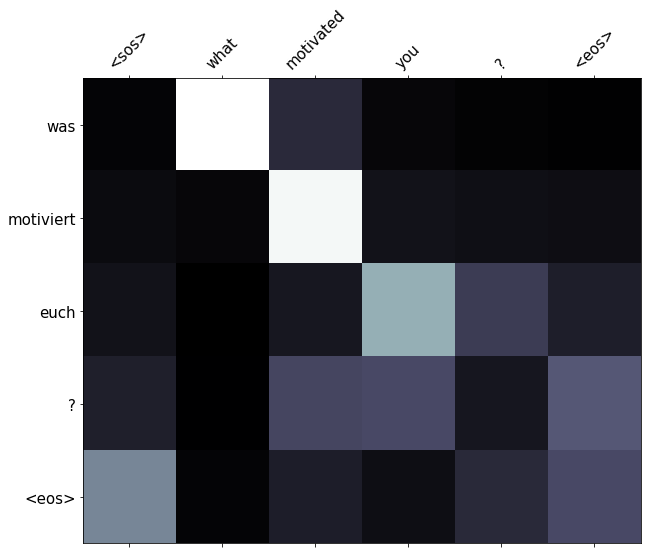

In [ ]:
example_idx = 66

src = vars(test_dataset.examples[example_idx])['src']
trg = vars(test_dataset.examples[example_idx])['trg']

print('source: {}'.format(src))
print('target: {}'.format(trg))
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print('predicted: {}'.format(translation))

display_attention(src, translation, attention)

## BLEU Testing
Here, we use BLEU to quantify the performance of model.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    """Func to calculate bleu result
    """
    
    trgs = []
    pred_trgs = []
    counter = 0 
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        # del <eos> token
        pred_trg = pred_trg[:-1]
        # 
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs),pred_trgs,trgs


In [ ]:
bleu_score,a,b = calculate_bleu(test_dataset, SRC, TRG, model, device)

print('BLEU score: {}'.format(bleu_score*100))


BLEU score: 29.90173681318095
